In [1]:
""" 

Goal: Hybrid Physics-ML Model for Anomaly Detection in RO Systems

Target: Differential Pressure, Permeate Pressure, Feed Pressure

Physics Equation:
- Derived equation for Differential Pressure based on RO system principles
- Differential Pressure = Feed Pressure - Permeate Pressure

Framework Steps
1. Data Preprocessing
2. Segregation of inputs and outputs 
3. Identify  the set of strongly-correlated  inputs to the target output
4. Prepare cross-features and lag feature for inputs to the target output 
5. Select the top 5 features most influencing towards the target output 
6. Derive physics equation for all target output (Differential Pressure, Permeate Pressure, Feed Pressure)
    1. Obtain physics equation of Differential Pressure
    2. Differential Pressure = Feed Pressure - Permeate Pressure 
7. Residual = Actual data - physics-based data 
8. Obtain predicted Residual from ML model
    - x: set of top 5 features to a target 
    - y: residual
9. Final Prediction = physics value + ML predicted residual  against the original value of the target output and mark anomaly


 """

' \n\nGoal: Hybrid Physics-ML Model for Anomaly Detection in RO Systems\n\nTarget: Differential Pressure, Permeate Pressure, Feed Pressure\n\nPhysics Equation:\n- Derived equation for Differential Pressure based on RO system principles\n- Differential Pressure = Feed Pressure - Permeate Pressure\n\nFramework Steps\n1. Data Preprocessing\n2. Segregation of inputs and outputs \n3. Identify  the set of strongly-correlated  inputs to the target output\n4. Prepare cross-features and lag feature for inputs to the target output \n5. Select the top 5 features most influencing towards the target output \n6. Derive physics equation for all target output (Differential Pressure, Permeate Pressure, Feed Pressure)\n    1. Obtain physics equation of Differential Pressure\n    2. Differential Pressure = Feed Pressure - Permeate Pressure \n7. Residual = Actual data - physics-based data \n8. Obtain predicted Residual from ML model\n    - x: set of top 5 features to a target \n    - y: residual\n9. Final

In [1]:
""" Auto reload modules when change exists """
%load_ext autoreload
%autoreload 2

In [2]:
""" Import necessary libraries """

import sys, os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np

from data_processor import DataProcessor
# from data_processor import CycleProcessor
from feature_engineering import FeatureEngineering, PhysicsBasedFeatures
# from model.coarse_feature_selection.cfs import random_forest_regressor
# from model.lstm_model.enhanced_lstm import lstm_model

In [4]:
""" 1. Data Preprocessing """
file_path = '../data/raw/data_factory_1.xlsx'
dp = DataProcessor(file_path)
dp.change_pivot('timestamp', 'param_name', 'value')

# drop missing values of input features
dp.drop_NA_with_feature(features=['FeedFlow','FeedTemperature'])

# standardize the feature names
dp.rename_column_to_timestamp('timestamp')
if 'Permeate Pressure' in dp.list_columns():
    dp.rename_column_to_permeatepressure('Permeate Pressure')

dp.list_columns()

['timestamp', 'ConcentrateFlow', 'ConcentratePressure', 'DifferentialPressure', 'FeedConductivity', 'FeedFlow', 'FeedPressure', 'FeedTemperature', 'Permeate Pressure', 'PermeateConductivity', 'PermeateFlow', 'Recovery']
['timestamp', 'ConcentrateFlow', 'ConcentratePressure', 'DifferentialPressure', 'FeedConductivity', 'FeedFlow', 'FeedPressure', 'FeedTemperature', 'PermeatePressure', 'PermeateConductivity', 'PermeateFlow', 'Recovery']


['timestamp',
 'ConcentrateFlow',
 'ConcentratePressure',
 'DifferentialPressure',
 'FeedConductivity',
 'FeedFlow',
 'FeedPressure',
 'FeedTemperature',
 'PermeatePressure',
 'PermeateConductivity',
 'PermeateFlow',
 'Recovery']

In [13]:
dp.df.to_csv('../data/physics/processed_data_factory_1.csv', index=False)

In [5]:
""" 2. Segrategation of inputs and outputs
    
    Inputs: 
        FeedFlow
        FeedPressure
        FeedTemperature
        FeedConductivity 
        Recovery

    Outputs:
        DifferentialPressure        
        PermeateFlow
        PermeatePressure
        PermeateConductivity
        ConcentrateFlow
        ConcentratePressure
        ConcentrateConductivity
        
"""


input_features = ['FeedFlow','FeedPressure','FeedTemperature','FeedConductivity','Recovery']
output_features = ['DifferentialPressure','PermeateFlow','PermeatePressure','PermeateConductivity',
                   'ConcentrateFlow','ConcentratePressure']



In [8]:
import pandas as pd
import numpy as np

def assign_ro_cycles(df, time_gap_hours=12, dp_drop_threshold=-25, cooldown_hours=72):
    """
    Identifies RO cycles based on cleaning events (Downtime or Pressure Reset).
    
    Parameters:
    - df: DataFrame containing 'timestamp' and 'DifferentialPressure'
    - time_gap_hours: Minimum downtime (hours) to trigger a new cycle (default 12h)
    - dp_drop_threshold: Minimum DP drop (negative bar) to trigger a new cycle (default -25 bar)
    - cooldown_hours: Minimum time between starts to prevent duplicate triggers (default 72h)
    
    Returns:
    - df: Original DataFrame with two new columns: 'cycle_id' and 'cycle_time'
    """
    # 1. Prepare Data
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # 2. Calculate Diffs
    # Calculate time gap in hours
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds() / 3600
    # Calculate DP change
    df['dp_diff'] = df['DifferentialPressure'].diff()
    
    # 3. Detect Start Conditions
    # Condition A: Machine was off for cleaning/maintenance
    cond_downtime = df['time_diff'] > time_gap_hours
    
    # Condition B: Massive pressure drop (Fouling removed)
    cond_cleaning = df['dp_diff'] < dp_drop_threshold
    
    # Get all indices where a cycle *might* start
    potential_starts = df[cond_downtime | cond_cleaning].index.tolist()
    
    # 4. Filter Starts (Debouncing)
    # Always include the very first data point as Cycle 1
    cycle_start_indices = [0]
    last_start_time = df.loc[0, 'timestamp']
    
    for idx in potential_starts:
        # Skip index 0 as it's already added
        if idx == 0: continue
            
        curr_time = df.loc[idx, 'timestamp']
        hours_since_last_cycle = (curr_time - last_start_time).total_seconds() / 3600
        
        # Only accept this new cycle if enough time has passed since the last one
        if hours_since_last_cycle > cooldown_hours:
            cycle_start_indices.append(idx)
            last_start_time = curr_time
            
    # 5. Assign IDs and Calculate Duration
    df['cycle_id'] = 0
    df['cycle_time'] = 0.0
    
    for i, start_idx in enumerate(cycle_start_indices):
        cycle_id = i + 1
        
        # Find the end of this cycle (it ends where the next one begins)
        if i < len(cycle_start_indices) - 1:
            end_idx = cycle_start_indices[i+1]
        else:
            end_idx = len(df)
            
        # Assign ID to the slice
        df.loc[start_idx:end_idx-1, 'cycle_id'] = cycle_id
        
        # Calculate Cycle Time (Cumulative Hours from start)
        cycle_start_ts = df.loc[start_idx, 'timestamp']
        timestamps_in_cycle = df.loc[start_idx:end_idx-1, 'timestamp']
        
        # Vectorized calculation is faster than a loop
        df.loc[start_idx:end_idx-1, 'cycle_time'] = (timestamps_in_cycle - cycle_start_ts).dt.total_seconds() / 3600
        
    return df



In [ ]:
# --- How to Run ---

df_final = assign_ro_cycles(dp.df)

# # View Results
print(df_final[['timestamp', 'DifferentialPressure', 'cycle_id', 'cycle_time']].head())

param_name           timestamp  DifferentialPressure  cycle_id  cycle_time
0          2022-11-01 00:00:00             59.811424         1         0.0
1          2022-11-01 01:00:00             59.793070         1         1.0
2          2022-11-01 02:00:00             59.789896         1         2.0
3          2022-11-01 03:00:00             59.742965         1         3.0
4          2022-11-01 04:00:00             59.799096         1         4.0


In [10]:
df_final.to_csv('../data/physics/cycle.csv', index=False)

In [7]:
# inputs = dp.df[input_features]
# outputs = dp.df[output_features]

In [8]:
# inputs.head()

In [11]:
"""
    3. Identify  the set of strongly-correlated  inputs to the target output
    4. Prepare cross-features and lag feature for inputs to the target output 

"""

fe = FeatureEngineering(dp)


# Create Cross Features and Lag Features
drop_features_cross = ['Recovery', 'PermeateFlow', 'PermeateConductivity', 'PermeatePressure', 'DifferentialPressure']

fe.generate_cross_features(drop_features=drop_features_cross)
fe.lag_engineer(mode='global')

In [12]:
fe.df.head()

,timestamp,ConcentrateFlow,ConcentratePressure,DifferentialPressure,FeedConductivity,FeedFlow,FeedPressure,FeedTemperature,PermeatePressure,PermeateConductivity,...,PermeateFlow_lag_1,PermeateFlow_lag_2,PermeateFlow_lag_3,PermeateFlow_lag_6,PermeateFlow_lag_12,Recovery_lag_1,Recovery_lag_2,Recovery_lag_3,Recovery_lag_6,Recovery_lag_12
0,2022-11-01 00:00:00,119.058464,254.427083,59.811424,238.884183,387.863646,273.325000,83.620000,33.441771,2.684261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-01 01:00:00,119.284861,254.408333,59.793070,239.050850,388.577708,273.159583,83.740000,33.405078,2.690898,...,269.623333,NaN,NaN,NaN,NaN,69.427135,NaN,NaN,NaN,NaN
2,2022-11-01 02:00:00,118.848508,254.044583,59.789896,239.117517,386.958541,272.952917,83.768333,33.316614,2.695333,...,270.177500,269.623333,NaN,NaN,NaN,69.401548,69.427135,NaN,NaN,NaN
3,2022-11-01 03:00:00,118.631324,253.052917,59.742965,239.234183,388.434167,271.841667,84.445000,33.036159,2.644088,...,269.188750,270.177500,269.623333,NaN,NaN,69.404638,69.401548,69.427135,NaN,NaN
4,2022-11-01 04:00:00,118.826094,254.352500,59.799096,239.217517,387.695000,273.296667,84.073333,33.177526,2.674923,...,270.778750,269.188750,270.177500,NaN,NaN,69.566374,69.404638,69.401548,NaN,NaN


In [13]:
fe.df.columns.tolist()

['timestamp',
 'ConcentrateFlow',
 'ConcentratePressure',
 'DifferentialPressure',
 'FeedConductivity',
 'FeedFlow',
 'FeedPressure',
 'FeedTemperature',
 'PermeatePressure',
 'PermeateConductivity',
 'PermeateFlow',
 'Recovery',
 'ConcentrateFlow_x_ConcentratePressure',
 'ConcentrateFlow_x_FeedConductivity',
 'ConcentrateFlow_x_FeedFlow',
 'ConcentrateFlow_x_FeedPressure',
 'ConcentrateFlow_x_FeedTemperature',
 'ConcentratePressure_x_FeedConductivity',
 'ConcentratePressure_x_FeedFlow',
 'ConcentratePressure_x_FeedPressure',
 'ConcentratePressure_x_FeedTemperature',
 'FeedConductivity_x_FeedFlow',
 'FeedConductivity_x_FeedPressure',
 'FeedConductivity_x_FeedTemperature',
 'FeedFlow_x_FeedPressure',
 'FeedFlow_x_FeedTemperature',
 'FeedPressure_x_FeedTemperature',
 'ConcentrateFlow_lag_1',
 'ConcentrateFlow_lag_2',
 'ConcentrateFlow_lag_3',
 'ConcentrateFlow_lag_6',
 'ConcentrateFlow_lag_12',
 'ConcentratePressure_lag_1',
 'ConcentratePressure_lag_2',
 'ConcentratePressure_lag_3',
 'Co

In [16]:
# total number of features after feature engineering
features = fe.df.columns.tolist()
len(features)

82

In [13]:
# fe.df.shape

In [14]:
import os
import time
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm  # Jupyter-friendly


def random_forest_regressor(
    dp,
    target_colums,
    features,
    plant_name,
    test_size=0.2,
    random_state=42,
    top_num=5,
    max_rows=10000,
    n_estimators=200,
    rf_chunk=25,         # how many trees to add per progress update
    shap_rows=400,       # how many rows to use for SHAP
    shap_batch=50        # batch size for SHAP progress updates
):
    steps = [
        "Data Splitting & Sampling",
        "Training Full RandomForest (tree progress)",
        "Feature Selection (Top 4×K)",
        "Training Refined RF Model (tree progress)",
        "Calculating SHAP Values (row progress)",
        "Saving Files & Plotting"
    ]

    # Remove non-feature cols
    features = [f for f in features if f not in ["cycle_id", "cycle_time"]]

    # Main pipeline bar
    with tqdm(total=len(steps), desc="Processing", colour="grey") as pbar:
        t0 = time.time()

        # ---------- Step 1 ----------
        pbar.set_description(f"Processing: {steps[0]}")

        all_cols = features + [target_colums]
        df = dp.df[all_cols].dropna()

        # Sample
        if len(df) > max_rows:
            selected_data = df.sample(n=max_rows, random_state=random_state)
            pbar.write(f"Sampled {max_rows} rows from {len(df)} total.")
        else:
            selected_data = df
            pbar.write(f"Using {len(df)} rows (no sampling).")

        X_train, X_test, y_train, y_test = train_test_split(
            selected_data[features],
            selected_data[target_colums],
            test_size=test_size,
            random_state=random_state,
            shuffle=True  # feature selection stage: shuffle is fine
        )

        pbar.write(f"✅ {steps[0]} Complete | Train={len(X_train)}, Test={len(X_test)}")
        pbar.update(1)

        # ---------- Step 2 ----------
        pbar.set_description(f"Processing: {steps[1]}")

        # warm_start lets us "grow" the forest and show progress
        rf = RandomForestRegressor(
            n_estimators=0,
            warm_start=True,
            random_state=random_state,
            n_jobs=-1
        )

        built = 0
        with tqdm(total=n_estimators, desc="Full RF: trees", leave=False) as t_rf:
            while built < n_estimators:
                nxt = min(built + rf_chunk, n_estimators)
                rf.set_params(n_estimators=nxt)
                rf.fit(X_train, y_train.values.ravel())
                t_rf.update(nxt - built)
                built = nxt

        pbar.write(f"✅ {steps[1]} Complete | Trees={n_estimators}")
        pbar.update(1)

        # ---------- Step 3 ----------
        pbar.set_description(f"Processing: {steps[2]}")

        importances = rf.feature_importances_
        fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
        top_features = fi.head(4 * top_num).index.tolist()

        pbar.write(f"✅ {steps[2]} Complete | Selected={len(top_features)}")
        pbar.update(1)

        # ---------- Step 4 ----------
        pbar.set_description(f"Processing: {steps[3]}")

        X_sub = X_train[top_features]
        y_sub = y_train

        rf_small = RandomForestRegressor(
            n_estimators=0,
            warm_start=True,
            random_state=random_state,
            n_jobs=-1
        )

        built = 0
        with tqdm(total=n_estimators, desc="Refined RF: trees", leave=False) as t_rf2:
            while built < n_estimators:
                nxt = min(built + rf_chunk, n_estimators)
                rf_small.set_params(n_estimators=nxt)
                rf_small.fit(X_sub, y_sub.values.ravel())
                t_rf2.update(nxt - built)
                built = nxt

        pbar.write(f"✅ {steps[3]} Complete | Trees={n_estimators}")
        pbar.update(1)

        # ---------- Step 5 ----------
        pbar.set_description(f"Processing: {steps[4]}")

        explainer = shap.TreeExplainer(rf_small)

        n_shap = min(shap_rows, len(X_sub))
        X_sub_sample = X_sub.sample(n=n_shap, random_state=random_state)

        shap_chunks = []
        with tqdm(total=n_shap, desc="SHAP: rows", leave=False) as t_shap:
            for start in range(0, n_shap, shap_batch):
                end = min(start + shap_batch, n_shap)
                batch = X_sub_sample.iloc[start:end]
                shap_vals_batch = explainer.shap_values(batch)
                shap_chunks.append(shap_vals_batch)
                t_shap.update(end - start)

        shap_values = np.vstack(shap_chunks)  # [n_shap, num_features]

        shap_importance = pd.Series(np.abs(shap_values).mean(axis=0), index=X_sub.columns)
        top_k_features = shap_importance.sort_values(ascending=False).head(top_num).index.tolist()

        pbar.write(f"✅ {steps[4]} Complete | Top-{top_num}: {top_k_features}")
        pbar.update(1)

        # ---------- Step 6 ----------
        pbar.set_description(f"Processing: {steps[5]}")

        os.makedirs("../data/physics/", exist_ok=True)

        # Save SHAP plot without blocking the notebook
        plt.figure(figsize=(8, 5))
        shap.summary_plot(shap_values, X_sub_sample, feature_names=X_sub.columns, max_display=top_num, show=False)
        plt.title(f"Top Features Influencing {target_colums}")
        plt.tight_layout()
        plt.savefig(f"../data/physics/top_features_{plant_name}_{target_colums}.png", dpi=300)
        plt.close()

        # Save features + data
        pd.DataFrame(top_k_features, columns=["feature_name"]).to_csv(
            f"../data/physics/top_k_features_{plant_name}_{target_colums}.csv", index=False
        )
        dp.df[top_k_features].to_csv(
            f"../data/physics/top_k_features_data_{plant_name}_{target_colums}.csv", index=False
        )

        pbar.write(f"✅ {steps[5]} Complete | Saved CSV + PNG")
        pbar.update(1)

        pbar.set_description(f"All Tasks Finished ({time.time() - t0:.1f}s)")

    return top_k_features


In [17]:
# Remove output features and unnecessary features from the feature list used for feature selection
fs = [f for f in features if f != '' and 'timestamp' not in f and f not in output_features and not any(output in f for output in output_features)]
fs

['FeedConductivity',
 'FeedFlow',
 'FeedPressure',
 'FeedTemperature',
 'Recovery',
 'FeedConductivity_x_FeedFlow',
 'FeedConductivity_x_FeedPressure',
 'FeedConductivity_x_FeedTemperature',
 'FeedFlow_x_FeedPressure',
 'FeedFlow_x_FeedTemperature',
 'FeedPressure_x_FeedTemperature',
 'FeedConductivity_lag_1',
 'FeedConductivity_lag_2',
 'FeedConductivity_lag_3',
 'FeedConductivity_lag_6',
 'FeedConductivity_lag_12',
 'FeedFlow_lag_1',
 'FeedFlow_lag_2',
 'FeedFlow_lag_3',
 'FeedFlow_lag_6',
 'FeedFlow_lag_12',
 'FeedPressure_lag_1',
 'FeedPressure_lag_2',
 'FeedPressure_lag_3',
 'FeedPressure_lag_6',
 'FeedPressure_lag_12',
 'FeedTemperature_lag_1',
 'FeedTemperature_lag_2',
 'FeedTemperature_lag_3',
 'FeedTemperature_lag_6',
 'FeedTemperature_lag_12',
 'Recovery_lag_1',
 'Recovery_lag_2',
 'Recovery_lag_3',
 'Recovery_lag_6',
 'Recovery_lag_12']

In [18]:
"""  5. Select Top 5 features most influencing towards the target output  
    TARGET: Differential Pressure
"""

top_k_features = random_forest_regressor(fe, 'DifferentialPressure', fs, plant_name='FACT1')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Sampled 10000 rows from 16159 total.
✅ Data Splitting & Sampling Complete | Train=8000, Test=2000


Full RF: trees:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Training Full RandomForest (tree progress) Complete | Trees=200
✅ Feature Selection (Top 4×K) Complete | Selected=20


Refined RF: trees:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Training Refined RF Model (tree progress) Complete | Trees=200


SHAP: rows:   0%|          | 0/400 [00:00<?, ?it/s]

✅ Calculating SHAP Values (row progress) Complete | Top-5: ['Recovery', 'FeedFlow', 'FeedConductivity_x_FeedTemperature', 'FeedConductivity', 'FeedConductivity_x_FeedPressure']
✅ Saving Files & Plotting Complete | Saved CSV + PNG


In [17]:
"""  5. Select Top 5 features most influencing towards the target output  
    TARGET: Concentrate Pressure
"""


output_features = ['DifferentialPressure','PermeateFlow','PermeatePressure','PermeateConductivity',
                   'ConcentrateFlow','ConcentratePressure']

# Remove output features and unnecessary features from the feature list used for feature selection
fs = [f for f in features if f != '' and 'timestamp' not in f and f not in output_features and not any(output in f for output in output_features)]

Starting Pipeline:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Data Splitting & Sampling Complete
✅ Training Full RandomForest Complete
✅ Feature Selection (Top 20) Complete
✅ Training Refined Model Complete
✅ Calculating SHAP Values Complete


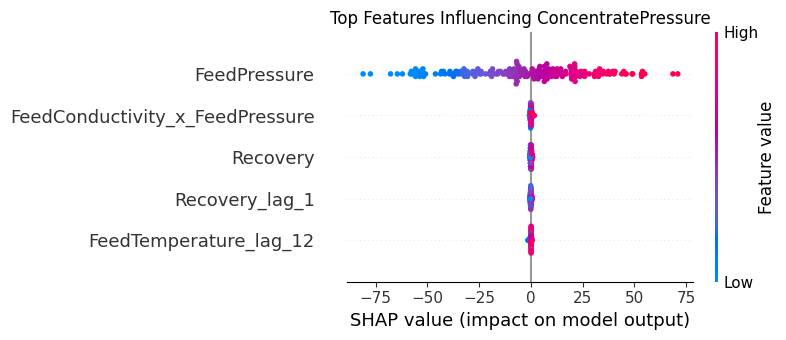

<Figure size 640x480 with 0 Axes>

In [18]:
top_k_features_CP = random_forest_regressor(fe, 'ConcentratePressure', fs, plant_name='FACT1')

In [39]:
"""  5. Select Top 5 features most influencing towards the target output  
    TARGET: Feed Pressure
"""



output_features = ['DifferentialPressure','PermeateFlow','PermeatePressure','PermeateConductivity',
                   'ConcentrateFlow','ConcentratePressure', 'FeedPressure']

fs = [f for f in features if f != '' and 'timestamp' not in f and f not in output_features and not any(output in f for output in output_features)]
fs

['FeedConductivity',
 'FeedFlow',
 'FeedTemperature',
 'Recovery',
 'FeedConductivity_x_FeedFlow',
 'FeedConductivity_x_FeedTemperature',
 'FeedFlow_x_FeedTemperature',
 'FeedConductivity_lag_1',
 'FeedConductivity_lag_2',
 'FeedConductivity_lag_3',
 'FeedConductivity_lag_6',
 'FeedConductivity_lag_12',
 'FeedFlow_lag_1',
 'FeedFlow_lag_2',
 'FeedFlow_lag_3',
 'FeedFlow_lag_6',
 'FeedFlow_lag_12',
 'FeedTemperature_lag_1',
 'FeedTemperature_lag_2',
 'FeedTemperature_lag_3',
 'FeedTemperature_lag_6',
 'FeedTemperature_lag_12',
 'Recovery_lag_1',
 'Recovery_lag_2',
 'Recovery_lag_3',
 'Recovery_lag_6',
 'Recovery_lag_12']

Processing: Training Full RandomForest:  17%|█▋        | 1/6 [00:00<00:00, 26.79it/s]

✅ Data Splitting & Sampling Complete


Processing: Training Refined Model:  50%|█████     | 3/6 [00:05<00:08,  2.90s/it]    

✅ Training Full RandomForest Complete
✅ Feature Selection (Top 20) Complete


Processing: Calculating SHAP Values:  67%|██████▋   | 4/6 [00:10<00:04,  2.45s/it]

✅ Training Refined Model Complete


Processing: Saving Files & Plotting:  83%|████████▎ | 5/6 [01:01<00:16, 16.90s/it]

✅ Calculating SHAP Values Complete


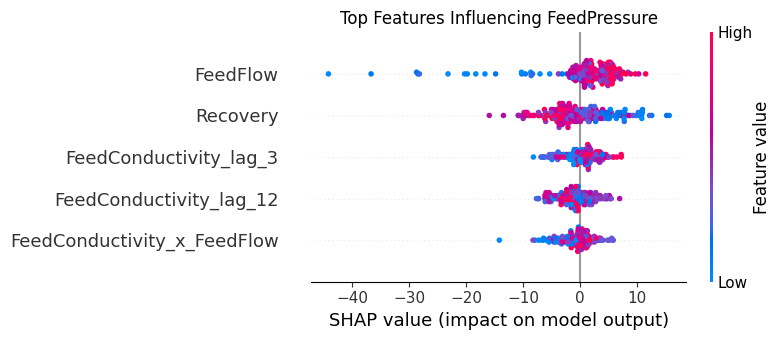

All Tasks Finished: 100%|██████████| 6/6 [01:01<00:00, 10.32s/it]                 


<Figure size 640x480 with 0 Axes>

In [40]:
top_k_features_FP = random_forest_regressor(fe, 'FeedPressure', fs, plant_name='FACT1')

In [21]:
""" 
    6. Derive physics-based features
    - Differential Pressure
    - Permeate Pressure
    - Feed Pressure
    
"""

pe = PhysicsBasedFeatures(fe)

fe.df['Physics_DP'] = pe.differential_pressure(flow_col='FeedFlow', temp_col='FeedTemperature', calibration_col='DifferentialPressure')

Auto-calibrated k: 0.0094


In [22]:
""" 
Physics-based Permeate Pressure = Feed Pressure - Physics-derived Differential Pressure

"""
fe.df['Physics_ConcentratePressure'] = fe.df['FeedPressure'] - fe.df['Physics_DP']


""" Physics-based Feed Pressure = Concentrate Pressure + Physics-derived Differential Pressure"""
fe.df["Physics_FeedPressure"] = fe.df['ConcentratePressure'] + fe.df['Physics_DP']
# fe.df['Physics_FeedPressure'] = fe.df['PermeatePressure'] + fe.df['Physics_DP']




In [23]:
fe.df.to_csv('../data/physics/physics_based_features_factory_1.csv', index=False)

Text(0.5, 1.0, 'Actual vs Physics-Based Differential Pressure')

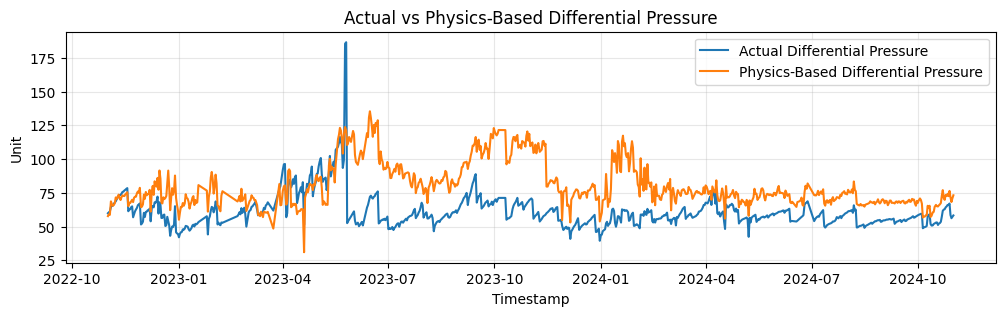

In [24]:
""" Plottting Actual vs Physics-Based Predicted """


import matplotlib.pyplot as plt


k = 20
df_plot = fe.df.iloc[::k].copy()

plt.figure(figsize=(12, 3))
plt.plot(df_plot['timestamp'], df_plot['DifferentialPressure'], label='Actual Differential Pressure')
plt.plot(df_plot['timestamp'], df_plot['Physics_DP'], label='Physics-Based Differential Pressure')
plt.xlabel('Timestamp')
plt.ylabel('Unit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Actual vs Physics-Based Differential Pressure')

In [25]:
# plt.figure(figsize=(12, 6))

# plt.subplot(2,1,1)
# plt.plot(df_plot['timestamp'], df_plot['PermeatePressure'], label='Actual Permeate Pressure')
# plt.plot(df_plot['timestamp'], df_plot['Physics_PermeatePressure'], label='Feed - Physics-Based DP')
# plt.xlabel('Timestamp')
# plt.ylabel('Unit')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.title('Actual Permeate Pressure vs (Feed Pressure - Physics-Based DP)')

# plt.subplot(2,1,2)
# plt.plot(df_plot['timestamp'], df_plot['ConcentratePressure'], label='Actual Concentrate Pressure')
# plt.plot(df_plot['timestamp'], df_plot['Physics_PermeatePressure'], label='Feed - Physics-Based DP')
# plt.xlabel('Timestamp')
# plt.ylabel('Unit')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.title('Actual Concentrate Pressure vs (Feed Pressure - Physics-Based DP)')

# plt.tight_layout()

In [26]:
# plt.figure(figsize=(12, 6))

# plt.subplot(2,1,1)
# plt.plot(df_plot['timestamp'], df_plot['FeedPressure'], label='Actual Feed Pressure')
# plt.plot(df_plot['timestamp'], df_plot['Physics_FeedPressure'], label='Permeate + Physics-Based DP')
# plt.xlabel('Timestamp')
# plt.ylabel('Unit')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.title('Actual Feed Pressure vs (Permeate Pressure + Physics-Based DP)')

# plt.subplot(2,1,2)
# plt.plot(df_plot['timestamp'], df_plot['ConcentratePressure'], label='Actual Feed Pressure')
# plt.plot(df_plot['timestamp'], df_plot['Physics_Test'], label='Concentrate Pressure - Physics-Based DP')
# plt.xlabel('Timestamp')
# plt.ylabel('Unit')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.title('Actual Feed Pressure vs (Concentrate Pressure + Physics-Based DP)')

# plt.tight_layout()

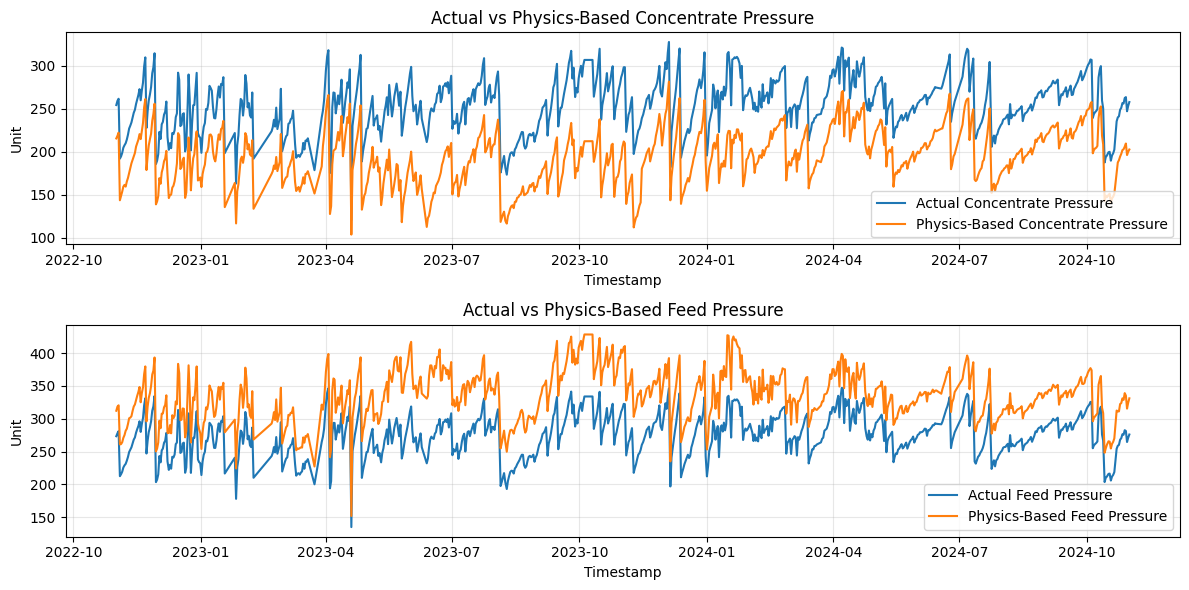

In [27]:
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(df_plot['timestamp'], df_plot['ConcentratePressure'], label='Actual Concentrate Pressure' )
plt.plot(df_plot['timestamp'], df_plot['Physics_ConcentratePressure'], label='Physics-Based Concentrate Pressure' )
plt.xlabel('Timestamp')
plt.ylabel('Unit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Actual vs Physics-Based Concentrate Pressure')
plt.subplot(2,1,2)
plt.plot(df_plot['timestamp'], df_plot['FeedPressure'], label='Actual Feed Pressure')
plt.plot(df_plot['timestamp'], df_plot['Physics_FeedPressure'], label='Physics-Based Feed Pressure')
plt.xlabel('Timestamp')
plt.ylabel('Unit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Actual vs Physics-Based Feed Pressure')

plt.tight_layout()


In [28]:
"""  7. Residual Calculation  
    Residual = Actual data - physics-based data
"""

# Differential Pressure Residual
fe.df['Residual_DP'] = fe.df['DifferentialPressure'] - fe.df['Physics_DP']
# Concentrate Pressure Residual
fe.df['Residual_CP'] = fe.df['ConcentratePressure'] - fe.df['Physics_ConcentratePressure']
# Feed Pressure Residual
fe.df['Residual_FP'] = fe.df['FeedPressure'] - fe.df['Physics_FeedPressure']

In [29]:
fe.df.head()

,timestamp,ConcentrateFlow,ConcentratePressure,DifferentialPressure,FeedConductivity,FeedFlow,FeedPressure,FeedTemperature,PermeatePressure,PermeateConductivity,...,Recovery_lag_2,Recovery_lag_3,Recovery_lag_6,Recovery_lag_12,Physics_DP,Physics_ConcentratePressure,Physics_FeedPressure,Residual_DP,Residual_CP,Residual_FP
0,2022-11-01 00:00:00,119.058464,254.427083,59.811424,238.884183,387.863646,273.325000,83.620000,33.441771,2.684261,...,NaN,NaN,NaN,NaN,57.692732,215.632268,312.119816,2.118692,38.794816,-38.794816
1,2022-11-01 01:00:00,119.284861,254.408333,59.793070,239.050850,388.577708,273.159583,83.740000,33.405078,2.690898,...,NaN,NaN,NaN,NaN,57.706975,215.452608,312.115309,2.086095,38.955725,-38.955725
2,2022-11-01 02:00:00,118.848508,254.044583,59.789896,239.117517,386.958541,272.952917,83.768333,33.316614,2.695333,...,69.427135,NaN,NaN,NaN,57.259841,215.693076,311.304424,2.530055,38.351507,-38.351507
3,2022-11-01 03:00:00,118.631324,253.052917,59.742965,239.234183,388.434167,271.841667,84.445000,33.036159,2.644088,...,69.401548,69.427135,NaN,NaN,56.703161,215.138506,309.756078,3.039804,37.914411,-37.914411
4,2022-11-01 04:00:00,118.826094,254.352500,59.799096,239.217517,387.695000,273.296667,84.073333,33.177526,2.674923,...,69.404638,69.401548,NaN,NaN,57.026261,216.270406,311.378761,2.772835,38.082094,-38.082094


In [ ]:
"""
    8. Obtain predicted Residual from ML model
    9. Final Prediction = physics value + ML predicted residual  against the original value of the target output and mark anomaly

    Goal:
        - Residual ML model
            x: set of top 5 features to a target 
            y: residual
        - Final Prediction = physics value + ML predicted residual against the original value of the target output and mark anomaly 


    Model Used: LSTM with Attention Mechanism
        Input: 5 features
        Output: 1 residual
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime
import ipywidgets as widgets
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display
from data_loader import time_series_loader,test_time_series_loader
import joblib  # 或使用 pickle
import copy


class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, output_dim)
        )
        
    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim]
        
        # Atttention Mechanisms
        attn_weights = self.attention(lstm_out)  # [batch_size, seq_len, 1]
        context = torch.sum(attn_weights * lstm_out, dim=1)  # [batch_size, hidden_dim]
        
        return self.fc(context)
def evaluate_model(model, val_loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            total_loss += loss.item() * X_val.size(0)
    return total_loss / len(val_loader.dataset)


def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=100, patience = 5):
    #early stopping
    best_val_loss = float('inf')
    epoch_without_improvement = 0
    best_model_weights = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_train.size(0)
        val_loss = evaluate_model(model, val_loader, device, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss/len(train_loader.dataset):.4f}  Test Loss: {val_loss:.4f}")

        #early_stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            epoch_without_improvement = 0
        else:
            epoch_without_improvement +=1

        if epoch_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_weights)
            break
    return model

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_loader import time_series_loader
import joblib
import os

def lstm_model(dp, selected_features, target_col, target_col_true, target_col_phys, feature_name, test_size=0.2, random_state=42, num_epochs=100, patience=5):
    
    # --- 1. Data Cleaning & Timestamp Extraction ---
    # We MUST include 'timestamp' here to ensure it stays aligned when we drop NaNs
    all_cols = selected_features + target_col + target_col_true + target_col_phys
    
    # Check if 'timestamp' is in columns, if not, assume index might be it or handle error
    time_col = 'timestamp' 
    cols_to_extract = all_cols + [time_col]
    
    if dp.df[all_cols].isnull().sum().sum() > 0:
        df_clean = dp.df[cols_to_extract].dropna()
    else:
        df_clean = dp.df[cols_to_extract]

    # Limit samples (truncate from the START to keep recent history)
    MAX_SAMPLES = 15000
    if len(df_clean) > MAX_SAMPLES:
        df_clean = df_clean.iloc[-MAX_SAMPLES:]

    # --- 2. Extract Values ---
    # Now extract the aligned timestamp array
    timestamps = pd.to_datetime(df_clean[time_col]).values
    
    X_raw = df_clean[selected_features].values
    y_raw = df_clean[target_col].values       # Residual Target
    y_phys_raw = df_clean[target_col_phys].values 
    y_true_raw = df_clean[target_col_true].values 

    # --- 3. Time-Series Split ---
    split_idx = int(len(X_raw) * (1 - test_size))
    
    X_train_full_raw = X_raw[:split_idx]
    X_test_raw = X_raw[split_idx:]
    
    y_train_full_raw = y_raw[:split_idx]
    y_test_raw = y_raw[split_idx:]
    
    # Split Timestamps and Reference Data
    y_phys_test_raw = y_phys_raw[split_idx:]
    y_true_test_raw = y_true_raw[split_idx:]
    timestamps_test = timestamps[split_idx:] 

    # --- 4. Inner Train/Val Split ---
    X_train_sub_raw, X_val_raw, y_train_sub_raw, y_val_raw = train_test_split(
        X_train_full_raw, y_train_full_raw, 
        test_size=0.2, random_state=random_state, shuffle=False
    )

    # --- 5. Scaling (Fixing Leakage) ---
    scaler_x = StandardScaler()
    X_train = scaler_x.fit_transform(X_train_sub_raw)
    X_val = scaler_x.transform(X_val_raw)
    X_test = scaler_x.transform(X_test_raw)
    
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train_sub_raw)
    y_val = scaler_y.transform(y_val_raw)
    y_test = scaler_y.transform(y_test_raw)
    
    # Save Scalers
    os.makedirs('../data/physics/', exist_ok=True)
    joblib.dump(scaler_x, f'../data/physics/scaler_x_{feature_name}.pkl')
    joblib.dump(scaler_y, f'../data/physics/scaler_y_{feature_name}.pkl')

    # --- 6. Training ---
    SEQ_LEN = 12
    train_loader = time_series_loader(X_train, y_train, seq_len=SEQ_LEN, batch_size=64, shuffle=False)
    val_loader = time_series_loader(X_val, y_val, seq_len=SEQ_LEN, batch_size=64, shuffle=False)
    test_loader = time_series_loader(X_test, y_test, seq_len=SEQ_LEN, batch_size=64, shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = EnhancedLSTM(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1, num_layers=2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.HuberLoss()
    
    print(f"Training on {device}...")
    train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=num_epochs, patience=patience)
    
    model_path = f"../data/physics/model_weights_{feature_name}.pth"
    torch.save(model.state_dict(), model_path)
    
    # --- 7. Analysis with Timestamps ---
    model_analysis(test_loader, model_path, scaler_x, scaler_y, target_col,
               y_phys_test_raw, y_true_test_raw, timestamps_test, device, feature_name)

def model_analysis(test_loader, model_weights_path, scaler_x, scaler_y, target_col,
               y_phys_test_raw, y_true_test_raw, timestamps_test, device, feature_name):
    
    # ... (Model loading and prediction logic stays the same) ...
    sample_X, _ = next(iter(test_loader))
    input_dim = sample_X.shape[2]
    model = EnhancedLSTM(input_dim=input_dim, hidden_dim=128, output_dim=1, num_layers=2).to(device)
    model.load_state_dict(torch.load(model_weights_path))
    model.eval()

    y_preds = []
    y_trues = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).cpu().numpy()
            y_preds.append(preds)
            y_trues.append(y_batch.numpy())

    y_pred = np.concatenate(y_preds, axis=0)
    
    print("Inverse transforming predictions...")
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Align Data
    seq_len = 12
    y_phys_labels = y_phys_test_raw[seq_len - 1:].flatten()
    y_true_labels = y_true_test_raw[seq_len - 1:].flatten()
    timestamps_plot = timestamps_test[seq_len - 1:]

    y_pred_total = y_phys_labels + y_pred

    # Metrics
    r2 = r2_score(y_true_labels, y_pred_total)
    mae = mean_absolute_error(y_true_labels, y_pred_total)
    print(f"R2 Score: {r2:.4f}, MAE: {mae:.4f}")
    correlation = np.corrcoef(y_true_labels, y_pred_total)[0, 1]
    print(f"Correlation (Trend Accuracy): {correlation:.4f}")

    # --- PLOTTING ALL DATA ---
    plt.figure(figsize=(40, 7)) # Made it slightly wider for better visibility
    
    # 1. Plot the FULL duration
    # We use thinner lines (linewidth=0.8) so high-frequency data is readable
    plt.plot(timestamps_plot, y_true_labels, 
             'b-', label=f'True Sensor Values', alpha=0.6, linewidth=0.8)
    
    plt.plot(timestamps_plot, y_pred_total, 
             'r--', label=f'Hybrid Predictions', alpha=0.8, linewidth=0.8)

    plt.title(f'Anomaly Detection: True vs Predicted ({feature_name})\nR2: {r2:.4f} | MAE: {mae:.4f} | Correlation (Trend Accuracy): {correlation:.4f}')
    plt.xlabel('Timestamp')
    plt.ylabel('Unit')
    
    # Date Formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # What the label says
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())     # Where the ticks appear
    plt.gcf().autofmt_xdate()   # Rotation and Alignment
    
    # Anomaly Detection (Plotting all anomalies)
    # 3-Sigma Rule (Z-Score approach)
    diff = np.abs(y_true_labels - y_pred_total)
    threshold = np.mean(diff) + 3 * np.std(diff) # Increased to 3 std dev to catch only major spikes
    anomalies = np.where(diff > threshold)[0]
    
    if len(anomalies) > 0:
        # Reduced dot size (s=20) to avoid crowding
        plt.scatter(timestamps_plot[anomalies], y_true_labels[anomalies], 
                    c='yellow', s=20, edgecolors='red', linewidth=0.5, 
                    label='Anomaly', zorder=3)
    
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'../data/physics/true_vs_predicted_FULL_{feature_name}.png', dpi=300)
    plt.show()



Training on cpu...


Epoch 1/50: 100%|██████████| 150/150 [00:03<00:00, 42.43it/s]


Epoch [1/50]  Train Loss: 0.2001  Test Loss: 0.2177


Epoch 2/50: 100%|██████████| 150/150 [00:02<00:00, 53.70it/s]


Epoch [2/50]  Train Loss: 0.2120  Test Loss: 0.1649


Epoch 3/50: 100%|██████████| 150/150 [00:02<00:00, 60.13it/s]


Epoch [3/50]  Train Loss: 0.2486  Test Loss: 0.1302


Epoch 4/50: 100%|██████████| 150/150 [00:02<00:00, 54.47it/s]


Epoch [4/50]  Train Loss: 0.2301  Test Loss: 0.0946


Epoch 5/50: 100%|██████████| 150/150 [00:02<00:00, 58.41it/s]


Epoch [5/50]  Train Loss: 0.2489  Test Loss: 0.0591


Epoch 6/50: 100%|██████████| 150/150 [00:02<00:00, 57.72it/s]


Epoch [6/50]  Train Loss: 0.2768  Test Loss: 0.0963


Epoch 7/50: 100%|██████████| 150/150 [00:02<00:00, 58.22it/s]


Epoch [7/50]  Train Loss: 0.2993  Test Loss: 0.1091


Epoch 8/50: 100%|██████████| 150/150 [00:02<00:00, 57.51it/s]


Epoch [8/50]  Train Loss: 0.2463  Test Loss: 0.0531


Epoch 9/50: 100%|██████████| 150/150 [00:02<00:00, 56.77it/s]


Epoch [9/50]  Train Loss: 0.2554  Test Loss: 0.0616


Epoch 10/50: 100%|██████████| 150/150 [00:02<00:00, 60.12it/s]


Epoch [10/50]  Train Loss: 0.2144  Test Loss: 0.0389


Epoch 11/50: 100%|██████████| 150/150 [00:02<00:00, 59.35it/s]


Epoch [11/50]  Train Loss: 0.2039  Test Loss: 0.0524


Epoch 12/50: 100%|██████████| 150/150 [00:02<00:00, 57.32it/s]


Epoch [12/50]  Train Loss: 0.2022  Test Loss: 0.0476


Epoch 13/50: 100%|██████████| 150/150 [00:02<00:00, 59.71it/s]


Epoch [13/50]  Train Loss: 0.1959  Test Loss: 0.0478


Epoch 14/50: 100%|██████████| 150/150 [00:02<00:00, 58.74it/s]


Epoch [14/50]  Train Loss: 0.1921  Test Loss: 0.0515


Epoch 15/50: 100%|██████████| 150/150 [00:02<00:00, 59.08it/s]


Epoch [15/50]  Train Loss: 0.1905  Test Loss: 0.0499


Epoch 16/50: 100%|██████████| 150/150 [00:02<00:00, 57.52it/s]


Epoch [16/50]  Train Loss: 0.1885  Test Loss: 0.0499


Epoch 17/50: 100%|██████████| 150/150 [00:02<00:00, 58.36it/s]


Epoch [17/50]  Train Loss: 0.1861  Test Loss: 0.0496


Epoch 18/50: 100%|██████████| 150/150 [00:02<00:00, 57.21it/s]


Epoch [18/50]  Train Loss: 0.1843  Test Loss: 0.0498


Epoch 19/50: 100%|██████████| 150/150 [00:03<00:00, 46.13it/s]


Epoch [19/50]  Train Loss: 0.1826  Test Loss: 0.0500


Epoch 20/50: 100%|██████████| 150/150 [00:02<00:00, 55.38it/s]


Epoch [20/50]  Train Loss: 0.1805  Test Loss: 0.0513
Early stopping at epoch 20
Inverse transforming predictions...
R2 Score: 0.0770, MAE: 3.6897
Correlation (Trend Accuracy): 0.8856


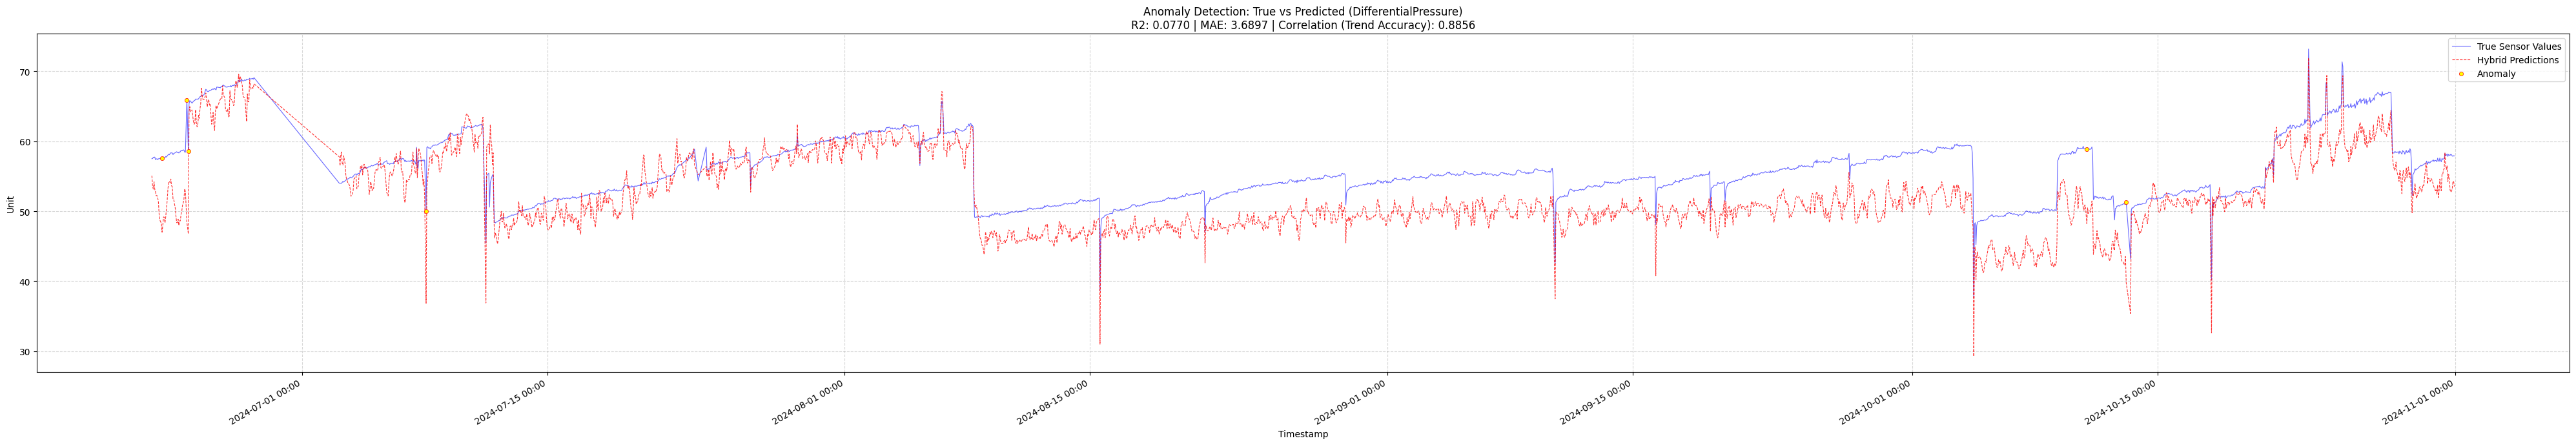

In [31]:
""" Final Prediction for Differential Pressure using Hybrid Physics-ML Model """


lstm_model(fe, selected_features=top_k_features, target_col=['Residual_DP'], target_col_true=['DifferentialPressure'], target_col_phys=['Physics_DP'], feature_name='DifferentialPressure', num_epochs=50, patience=10)

Training on cpu...


Epoch 1/50: 100%|██████████| 150/150 [00:03<00:00, 41.62it/s]


Epoch [1/50]  Train Loss: 0.2277  Test Loss: 0.0354


Epoch 2/50: 100%|██████████| 150/150 [00:03<00:00, 47.97it/s]


Epoch [2/50]  Train Loss: 0.1113  Test Loss: 0.0420


Epoch 3/50: 100%|██████████| 150/150 [00:03<00:00, 40.75it/s]


Epoch [3/50]  Train Loss: 0.1076  Test Loss: 0.0403


Epoch 4/50: 100%|██████████| 150/150 [00:03<00:00, 48.46it/s]


Epoch [4/50]  Train Loss: 0.1023  Test Loss: 0.0357


Epoch 5/50: 100%|██████████| 150/150 [00:02<00:00, 50.72it/s]


Epoch [5/50]  Train Loss: 0.0962  Test Loss: 0.0335


Epoch 6/50: 100%|██████████| 150/150 [00:03<00:00, 46.69it/s]


Epoch [6/50]  Train Loss: 0.0925  Test Loss: 0.0317


Epoch 7/50: 100%|██████████| 150/150 [00:03<00:00, 48.76it/s]


Epoch [7/50]  Train Loss: 0.0890  Test Loss: 0.0319


Epoch 8/50: 100%|██████████| 150/150 [00:03<00:00, 46.65it/s]


Epoch [8/50]  Train Loss: 0.0870  Test Loss: 0.0318


Epoch 9/50: 100%|██████████| 150/150 [00:02<00:00, 50.82it/s]


Epoch [9/50]  Train Loss: 0.0854  Test Loss: 0.0320


Epoch 10/50: 100%|██████████| 150/150 [00:02<00:00, 54.05it/s]


Epoch [10/50]  Train Loss: 0.0846  Test Loss: 0.0326


Epoch 11/50: 100%|██████████| 150/150 [00:03<00:00, 49.65it/s]


Epoch [11/50]  Train Loss: 0.0841  Test Loss: 0.0336


Epoch 12/50: 100%|██████████| 150/150 [00:03<00:00, 44.35it/s]


Epoch [12/50]  Train Loss: 0.0843  Test Loss: 0.0343


Epoch 13/50: 100%|██████████| 150/150 [00:04<00:00, 36.73it/s]


Epoch [13/50]  Train Loss: 0.0852  Test Loss: 0.0361


Epoch 14/50: 100%|██████████| 150/150 [00:03<00:00, 45.89it/s]


Epoch [14/50]  Train Loss: 0.0858  Test Loss: 0.0374


Epoch 15/50: 100%|██████████| 150/150 [00:03<00:00, 45.34it/s]


Epoch [15/50]  Train Loss: 0.0872  Test Loss: 0.0401


Epoch 16/50: 100%|██████████| 150/150 [00:03<00:00, 41.42it/s]


Epoch [16/50]  Train Loss: 0.0877  Test Loss: 0.0392
Early stopping at epoch 16
Inverse transforming predictions...
R2 Score: 0.9722, MAE: 3.7874
Correlation (Trend Accuracy): 0.9937


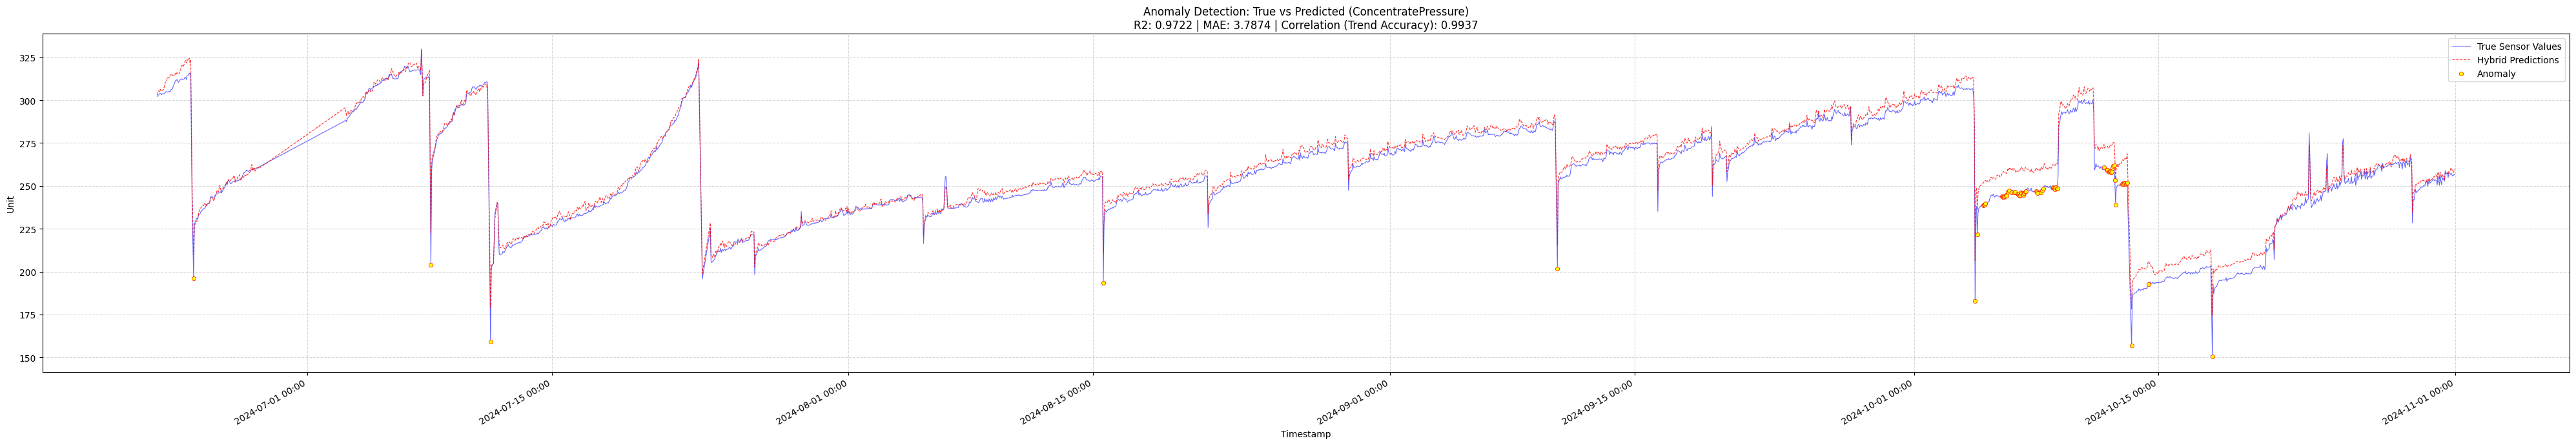

In [32]:
""" Final Prediction for Feed Concentrate Pressure using Hybrid Physics-ML Model"""

lstm_model(fe, selected_features=top_k_features_CP, target_col=['Residual_CP'], target_col_true=['ConcentratePressure'], target_col_phys=['Physics_ConcentratePressure'], feature_name='ConcentratePressure', num_epochs=50, patience=10)

Training on cpu...


Epoch 1/50: 100%|██████████| 150/150 [00:05<00:00, 26.63it/s]


Epoch [1/50]  Train Loss: 0.4026  Test Loss: 0.3234


Epoch 2/50: 100%|██████████| 150/150 [00:02<00:00, 55.92it/s]


Epoch [2/50]  Train Loss: 0.3992  Test Loss: 0.3240


Epoch 3/50: 100%|██████████| 150/150 [00:02<00:00, 57.91it/s]


Epoch [3/50]  Train Loss: 0.4254  Test Loss: 0.2209


Epoch 4/50: 100%|██████████| 150/150 [00:02<00:00, 53.31it/s]


Epoch [4/50]  Train Loss: 0.4542  Test Loss: 0.2846


Epoch 5/50: 100%|██████████| 150/150 [00:02<00:00, 57.07it/s]


Epoch [5/50]  Train Loss: 0.4441  Test Loss: 0.3057


Epoch 6/50: 100%|██████████| 150/150 [00:02<00:00, 51.95it/s]


Epoch [6/50]  Train Loss: 0.4370  Test Loss: 0.3113


Epoch 7/50: 100%|██████████| 150/150 [00:03<00:00, 47.96it/s]


Epoch [7/50]  Train Loss: 0.4332  Test Loss: 0.3047


Epoch 8/50: 100%|██████████| 150/150 [00:02<00:00, 54.79it/s]


Epoch [8/50]  Train Loss: 0.4487  Test Loss: 0.2963


Epoch 9/50: 100%|██████████| 150/150 [00:02<00:00, 56.05it/s]


Epoch [9/50]  Train Loss: 0.4333  Test Loss: 0.3057


Epoch 10/50: 100%|██████████| 150/150 [00:02<00:00, 54.90it/s]


Epoch [10/50]  Train Loss: 0.4301  Test Loss: 0.3213


Epoch 11/50: 100%|██████████| 150/150 [00:03<00:00, 43.39it/s]


Epoch [11/50]  Train Loss: 0.4232  Test Loss: 0.3543


Epoch 12/50: 100%|██████████| 150/150 [00:03<00:00, 46.26it/s]


Epoch [12/50]  Train Loss: 0.4232  Test Loss: 0.3803


Epoch 13/50: 100%|██████████| 150/150 [00:02<00:00, 52.27it/s]


Epoch [13/50]  Train Loss: 0.4131  Test Loss: 0.4222
Early stopping at epoch 13
Inverse transforming predictions...
R2 Score: 0.8743, MAE: 9.3653
Correlation (Trend Accuracy): 0.9886


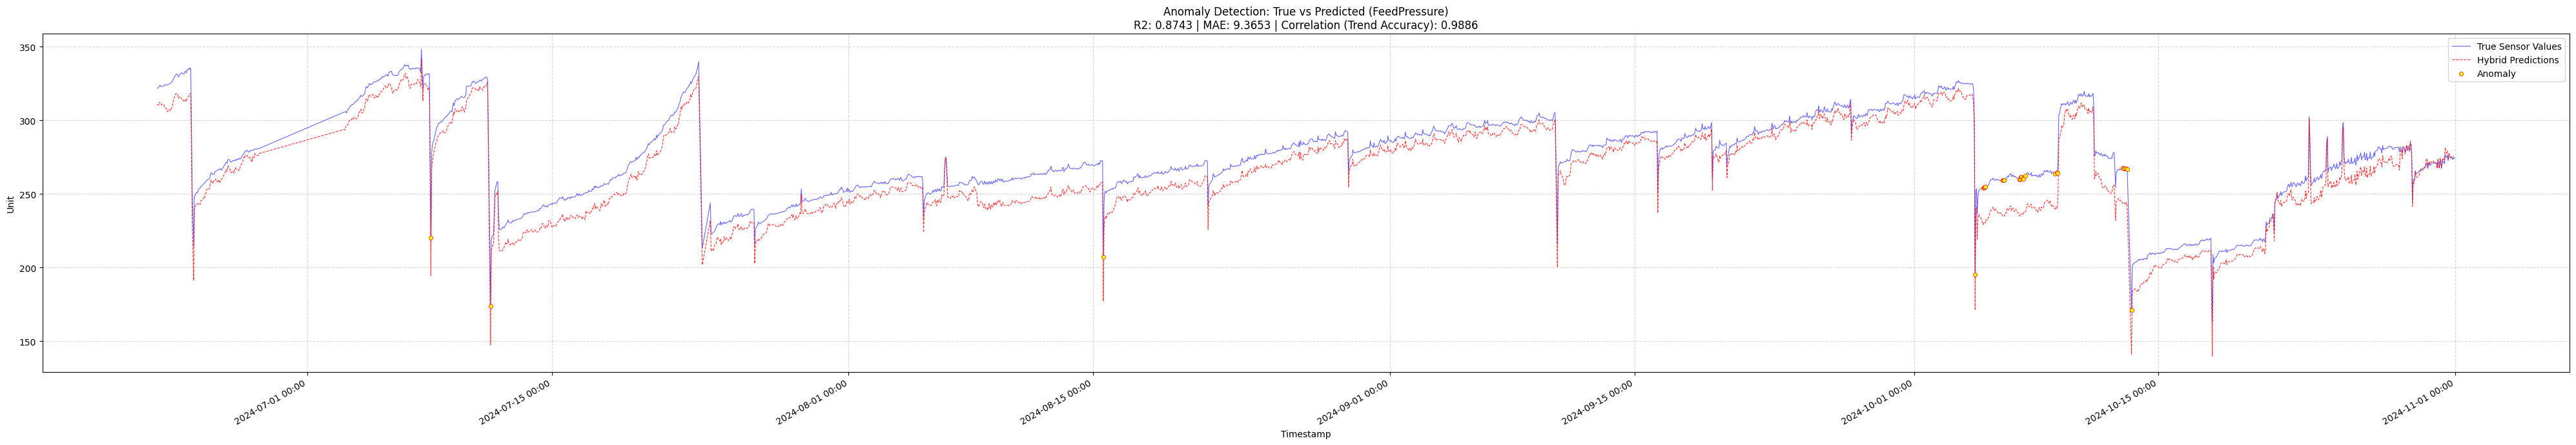

In [41]:
""" Final Prediction for Feed Pressure using Hybrid Physics-ML Model """

lstm_model(fe, selected_features=top_k_features_FP, target_col=['Residual_FP'], target_col_true=['FeedPressure'], target_col_phys=['Physics_FeedPressure'], feature_name='FeedPressure', num_epochs=50, patience=10)

In [34]:
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# import joblib
# import os

# # --- 1. Define the Enhanced LSTM Model ---
# class EnhancedLSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
#         super().__init__()
#         self.lstm = nn.LSTM(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=0.2 if num_layers > 1 else 0
#         )
#         # Attention Mechanism
#         self.attention = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.Tanh(),
#             nn.Linear(hidden_dim, 1),
#             nn.Softmax(dim=1)
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim//2),
#             nn.ReLU(),
#             nn.Linear(hidden_dim//2, output_dim)
#         )
        
#     def forward(self, x):
#         # x: [batch_size, seq_len, input_dim]
#         lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim]
        
#         # Calculate Attention Weights
#         attn_weights = self.attention(lstm_out)  # [batch_size, seq_len, 1]
        
#         # Apply Attention (Weighted Sum)
#         context = torch.sum(attn_weights * lstm_out, dim=1)  # [batch_size, hidden_dim]
        
#         return self.fc(context)

# # --- 2. Training Helper Functions ---
# def evaluate_model(model, val_loader, device, criterion):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for X_val, y_val in val_loader:
#             X_val, y_val = X_val.to(device), y_val.to(device)
#             y_pred = model(X_val)
#             loss = criterion(y_pred, y_val)
#             total_loss += loss.item() * X_val.size(0)
#     return total_loss / len(val_loader.dataset)

# def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=100, patience=5):
#     best_val_loss = float('inf')
#     epoch_without_improvement = 0
#     best_model_weights = model.state_dict()

#     # Progress bar for Epochs
#     epoch_pbar = tqdm(range(num_epochs), desc="Training Progress", position=0)
    
#     for epoch in epoch_pbar:
#         model.train()
#         train_loss = 0
        
#         # Inner loop for Batches
#         for X_train, y_train in train_loader:
#             X_train, y_train = X_train.to(device), y_train.to(device)
#             optimizer.zero_grad()
#             y_pred = model(X_train)
#             loss = criterion(y_pred, y_train)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * X_train.size(0)
            
#         avg_train_loss = train_loss / len(train_loader.dataset)
#         val_loss = evaluate_model(model, val_loader, device, criterion)
        
#         # Update progress bar description
#         epoch_pbar.set_description(f"Ep {epoch+1} | Train: {avg_train_loss:.4f} | Val: {val_loss:.4f}")

#         # Early Stopping Logic
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model_weights = model.state_dict()
#             epoch_without_improvement = 0
#         else:
#             epoch_without_improvement += 1

#         if epoch_without_improvement >= patience:
#             print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
#             model.load_state_dict(best_model_weights)
#             break
            
#     return model

# # --- 3. Main Model Function ---
# def lstm_model(dp, selected_features, target_col, feature_name, test_size=0.2, random_state=42, num_epochs=100, patience=5):
    
#     # Ensure directories exist
#     os.makedirs('../data/model_data/', exist_ok=True)
#     os.makedirs('../model/', exist_ok=True)
#     os.makedirs('../img/', exist_ok=True)

#     # Prepare Data
#     if dp.df[selected_features + [target_col]].isnull().sum().sum() > 0:
#         df_dropna = dp.df[selected_features + [target_col]].dropna()
#     else:
#         df_dropna = dp.df[selected_features + [target_col]]

#     # Limit samples to avoid memory OOM on large datasets
#     MAX_SAMPLES = 20000 
#     if len(df_dropna) > MAX_SAMPLES:
#         df_dropna = df_dropna.iloc[-MAX_SAMPLES:]

#     X_raw = df_dropna[selected_features].values
#     y_raw = df_dropna[target_col].values.reshape(-1, 1)

#     # Time-Series Split (No Shuffling)
#     split_idx = int(len(X_raw) * (1 - test_size))
#     X_train_raw, X_test_raw = X_raw[:split_idx], X_raw[split_idx:]
#     y_train_raw, y_test_raw = y_raw[:split_idx], y_raw[split_idx:]
    
#     # Validation Split
#     X_train_sub, X_val, y_train_sub, y_val = train_test_split(
#         X_train_raw, y_train_raw, test_size=0.2, random_state=random_state, shuffle=False
#     )

#     # Scaling
#     scaler_x = StandardScaler()
#     X_train = scaler_x.fit_transform(X_train_sub)
#     X_val = scaler_x.transform(X_val)
#     X_test = scaler_x.transform(X_test_raw)
    
#     scaler_y = StandardScaler()
#     y_train = scaler_y.fit_transform(y_train_sub)
#     y_val = scaler_y.transform(y_val)
#     y_test = scaler_y.transform(y_test_raw)

#     # Save Scalers
#     joblib.dump(scaler_x, f'../data/model_data/scaler_x_{feature_name}.pkl')
#     joblib.dump(scaler_y, f'../data/model_data/scaler_y_{feature_name}.pkl')

#     # Data Loaders (Assuming time_series_loader is defined in your utils)
#     # Important: seq_len should match what you trained on (e.g., 72 hours window)
#     SEQ_LEN = 12 
#     from data_loader import time_series_loader # Ensure this import is active
    
#     train_loader = time_series_loader(X_train, y_train, seq_len=SEQ_LEN, batch_size=64, shuffle=False)
#     val_loader = time_series_loader(X_val, y_val, seq_len=SEQ_LEN, batch_size=64, shuffle=False)
#     test_loader = time_series_loader(X_test, y_test, seq_len=SEQ_LEN, batch_size=64, shuffle=False)

#     # Model Setup
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print(f"🚀 Training on {device}...")
    
#     model = EnhancedLSTM(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1, num_layers=2).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#     criterion = nn.HuberLoss() # Excellent choice for robust regression

#     # Train
#     model = train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=num_epochs, patience=patience)
    
#     # Save Model
#     model_weights_path = f"../model/model_weights_{feature_name}.pth"
#     torch.save(model.state_dict(), model_weights_path)
#     print(f"✅ Model saved to {model_weights_path}")

#     # Analyze
#     model_analysis(test_loader, model_weights_path, scaler_x, scaler_y, target_col, device, feature_name)

# # --- 4. The Corrected Analysis Function ---
# def model_analysis(test_loader, model_weights_path, scaler_x, scaler_y, target_col, device, feature_name):
    
#     # Load Model
#     # Note: We need to infer input_dim from the test_loader dataset
#     # Depending on your loader implementation, you might need to pass input_dim explicitly
#     sample_X, _ = next(iter(test_loader))
#     input_dim = sample_X.shape[2] 
    
#     model = EnhancedLSTM(input_dim=input_dim, hidden_dim=128, output_dim=1, num_layers=2).to(device)
#     model.load_state_dict(torch.load(model_weights_path))
#     model.eval()

#     y_preds = []
#     y_trues = []

#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             X_batch = X_batch.to(device)
#             preds = model(X_batch).cpu().numpy()
#             y_preds.append(preds)
#             y_trues.append(y_batch.numpy())

#     # Concatenate
#     y_pred = np.concatenate(y_preds, axis=0)
#     y_true = np.concatenate(y_trues, axis=0)

#     # --- CRITICAL FIX: Inverse Transform ---
#     # Convert Z-scores back to Real Units (e.g., Bar, m3/h)
#     print("🔄 Inverse transforming predictions to original scale...")
#     y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
#     y_true_orig = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    
#     # Metrics
#     r2 = r2_score(y_true_orig, y_pred_orig)
#     mae = mean_absolute_error(y_true_orig, y_pred_orig)
#     print(f"📊 Final Test Results -- R2: {r2:.4f}, MAE: {mae:.4f}")

#     # Plotting
#     plt.figure(figsize=(14, 6))
    
#     # Plot first 300 points for clarity
#     limit = min(300, len(y_true_orig))
    
#     plt.plot(y_true_orig[:limit], 'b-', label='Actual Data', alpha=0.6, linewidth=2)
#     plt.plot(y_pred_orig[:limit], 'r--', label='LSTM Prediction', alpha=0.8, linewidth=1.5)
    
#     plt.title(f'LSTM Performance: {feature_name}\nR2: {r2:.3f} | MAE: {mae:.3f}')
#     plt.xlabel('Time Steps (e.g., Hours)')
#     plt.ylabel(f'Value ({target_col})')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig(f'../img/lstm_result_{feature_name}.png', dpi=300)
#     plt.show()

In [35]:
# lstm_model(dp=fe, selected_features=top_k_features, target_col='DifferentialPressure', feature_name='DifferentialPressure')

In [36]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# import matplotlib.pyplot as plt

# def train_hybrid_model(df, target_col, physics_col, features, split_idx=10000):
#     """
#     df: DataFrame containing all data
#     target_col: The name of the actual target (e.g., 'DifferentialPressure')
#     physics_col: The name of the physics-calculated column
#     features: List of top 5 feature names (inputs)
#     split_idx: Index to split train/test (respecting time order)
#     """
    
#     # --- Step A: Create the Residual Target ---
#     # The ML model will ONLY try to learn this "error"
#     df['Residual_Target'] = df[target_col] - df[physics_col]
    
#     # --- Step B: Split Data (Time-Series Split) ---
#     # We don't use random split for final training because we want to see if it predicts FUTURE fouling
#     train = df.iloc[:split_idx].copy()
#     test = df.iloc[split_idx:].copy()
    
#     X_train = train[features]
#     y_train_resid = train['Residual_Target']
    
#     X_test = test[features]
#     y_test_resid = test['Residual_Target']
    
#     # --- Step C: Train Model on Residuals ---
#     print(f"Training Hybrid Model on {target_col} Residuals...")
#     rf_hybrid = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
#     rf_hybrid.fit(X_train, y_train_resid)
    
#     # --- Step D: Predict the Residual ---
#     # The model predicts the "Error correction"
#     train['pred_residual'] = rf_hybrid.predict(X_train)
#     test['pred_residual'] = rf_hybrid.predict(X_test)
    
#     # --- Step E: Reconstruct the Final Value ---
#     # Final = Physics + AI Correction
#     train['Hybrid_Prediction'] = train[physics_col] + train['pred_residual']
#     test['Hybrid_Prediction'] = test[physics_col] + test['pred_residual']
    
#     # --- Step F: Evaluate ---
#     # We compare the Hybrid Prediction against the ORIGINAL Actual Value
#     r2 = r2_score(test[target_col], test['Hybrid_Prediction'])
#     rmse = np.sqrt(mean_squared_error(test[target_col], test['Hybrid_Prediction']))
    
#     print(f"✅ Hybrid Model Performance:")
#     print(f"   R2 Score: {r2:.4f}")
#     print(f"   RMSE: {rmse:.4f}")
    
#     return rf_hybrid, train, test



In [37]:
# # --- Usage Example ---
# # Assuming you already have 'Physics_DP' calculated in your dataframe
# features = top_k_features  # From your previous SHAP step

# model, train_results, test_results = train_hybrid_model(
#     df=fe.df, 
#     target_col='DifferentialPressure', 
#     physics_col='Physics_DP', 
#     features=features
# )

In [38]:
# # Plotting the Test Set results
# plt.figure(figsize=(15, 6))

# # 1. Plot Actual Data (Truth)
# plt.plot(test_results['timestamp'], test_results['DifferentialPressure'], 
#          label='Actual Sensor Data', color='black', alpha=0.5)

# # 2. Plot Physics Only (The Baseline)
# plt.plot(test_results['timestamp'], test_results['Physics_DP'], 
#          label='Physics Formula Only', color='blue', linestyle='--')

# # 3. Plot Hybrid (The Result)
# plt.plot(test_results['timestamp'], test_results['Hybrid_Prediction'], 
#          label='Hybrid (Physics + AI)', color='red', linewidth=2)

# plt.title("Hybrid Model: Correcting Physics with AI")
# plt.legend()
# plt.show()